<a href="https://colab.research.google.com/github/JoeBens/Photographer-Classifier/blob/main/PRAT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 22 (delta 3), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (22/22), done.


In [ ]:
%cd deep-learning-polytech-tp6-7/

/content/deep-learning-polytech-tp6-7


In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"
PATH_PRAT = "/content/drive/MyDrive/images-photographes"


In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        # self.features = nn.Sequential(
        #     nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
        #     nn.Tanh(),
        #     nn.MaxPool2d((2, 2), stride=2, padding=0),
        #     nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
        #     nn.Tanh(),
        #     nn.MaxPool2d((2, 2), stride=2, padding=0),
        # )
        

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 10)
 
            # Reminder: The softmax is included in the loss, do not put it here
        )

        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = self.classifier

    # Method called when we apply the network to an input batch
    def forward(self, input):
        # bsize = input.size(0) # batch size
        # output = self.features(input) # output of the conv layers
        # output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        # output = self.classifier(output) # we compute the output of the fc layers

        return self.model(input)



def get_youcef_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    dataset = datasets.ImageFolder(PATH_PRAT,transform=transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_youcef_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


=== EPOCH 1 =====

[TRAIN Batch 000/014]	Time 4.736s (4.736s)	Loss 2.4130 (2.4130)	Prec@1   0.0 (  0.0)	Prec@5  37.5 ( 37.5)


<Figure size 432x288 with 0 Axes>

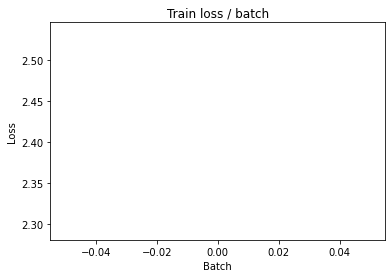


===============> Total time 13s	Avg loss 2.3724	Avg Prec@1 19.20 %	Avg Prec@5 62.95 %

[EVAL Batch 000/004]	Time 2.552s (2.552s)	Loss 2.5247 (2.5247)	Prec@1  18.8 ( 18.8)	Prec@5  75.0 ( 75.0)

===============> Total time 5s	Avg loss 2.5776	Avg Prec@1 15.62 %	Avg Prec@5 60.94 %



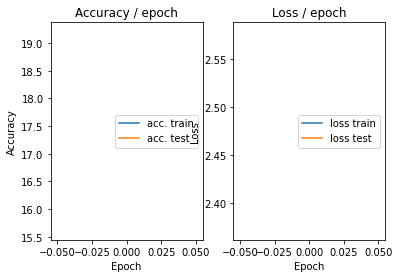

=== EPOCH 2 =====

[TRAIN Batch 000/014]	Time 2.634s (2.634s)	Loss 2.6679 (2.6679)	Prec@1  12.5 ( 12.5)	Prec@5  50.0 ( 50.0)


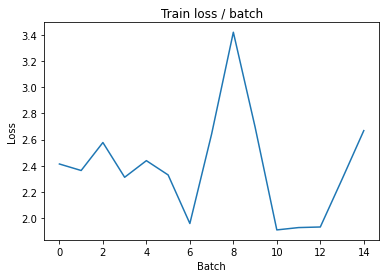


===============> Total time 13s	Avg loss 2.0452	Avg Prec@1 32.14 %	Avg Prec@5 74.11 %

[EVAL Batch 000/004]	Time 2.588s (2.588s)	Loss 2.3000 (2.3000)	Prec@1  12.5 ( 12.5)	Prec@5  62.5 ( 62.5)

===============> Total time 3s	Avg loss 2.0515	Avg Prec@1 23.44 %	Avg Prec@5 71.88 %



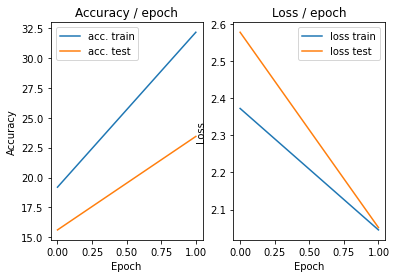

=== EPOCH 3 =====

[TRAIN Batch 000/014]	Time 2.364s (2.364s)	Loss 1.7537 (1.7537)	Prec@1  31.2 ( 31.2)	Prec@5  87.5 ( 87.5)


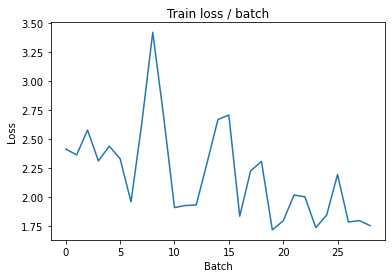


===============> Total time 13s	Avg loss 1.6251	Avg Prec@1 49.11 %	Avg Prec@5 90.18 %

[EVAL Batch 000/004]	Time 2.490s (2.490s)	Loss 1.7686 (1.7686)	Prec@1  31.2 ( 31.2)	Prec@5  81.2 ( 81.2)

===============> Total time 3s	Avg loss 1.7914	Avg Prec@1 31.25 %	Avg Prec@5 90.62 %



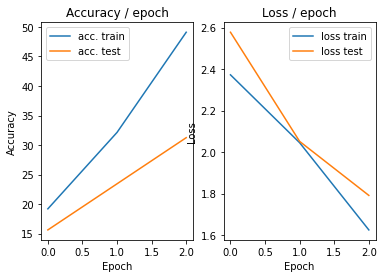

=== EPOCH 4 =====

[TRAIN Batch 000/014]	Time 2.453s (2.453s)	Loss 1.3116 (1.3116)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)


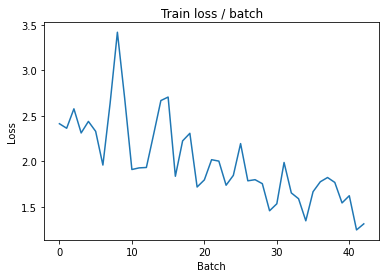


===============> Total time 12s	Avg loss 1.4199	Avg Prec@1 56.25 %	Avg Prec@5 96.43 %

[EVAL Batch 000/004]	Time 2.519s (2.519s)	Loss 1.9301 (1.9301)	Prec@1  18.8 ( 18.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.5712	Avg Prec@1 48.44 %	Avg Prec@5 92.19 %



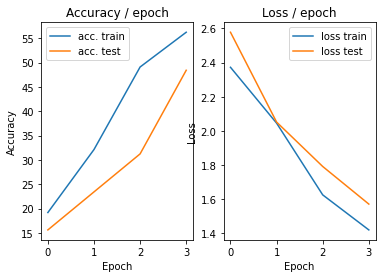

=== EPOCH 5 =====

[TRAIN Batch 000/014]	Time 1.507s (1.507s)	Loss 1.0691 (1.0691)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


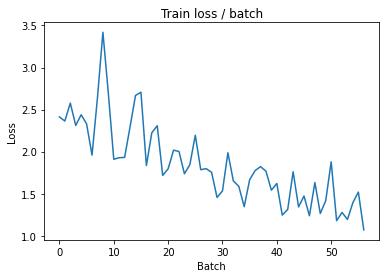


===============> Total time 13s	Avg loss 1.2767	Avg Prec@1 59.82 %	Avg Prec@5 97.77 %

[EVAL Batch 000/004]	Time 2.506s (2.506s)	Loss 1.6102 (1.6102)	Prec@1  56.2 ( 56.2)	Prec@5  87.5 ( 87.5)

===============> Total time 3s	Avg loss 1.5972	Avg Prec@1 50.00 %	Avg Prec@5 93.75 %



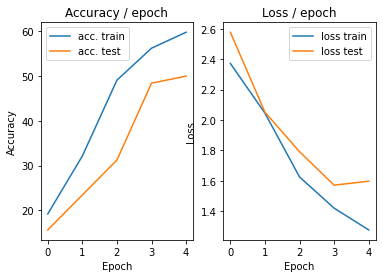

=== EPOCH 6 =====

[TRAIN Batch 000/014]	Time 1.829s (1.829s)	Loss 1.1751 (1.1751)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)


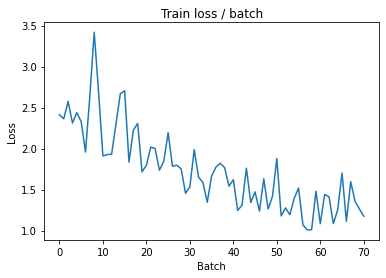


===============> Total time 13s	Avg loss 1.1494	Avg Prec@1 67.41 %	Avg Prec@5 96.88 %

[EVAL Batch 000/004]	Time 2.526s (2.526s)	Loss 1.7224 (1.7224)	Prec@1  18.8 ( 18.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.6157	Avg Prec@1 39.06 %	Avg Prec@5 95.31 %



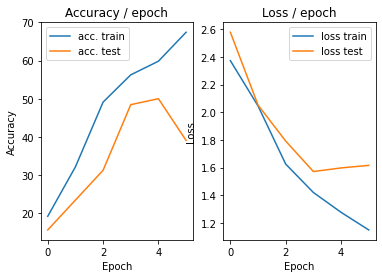

=== EPOCH 7 =====

[TRAIN Batch 000/014]	Time 1.967s (1.967s)	Loss 0.9560 (0.9560)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)


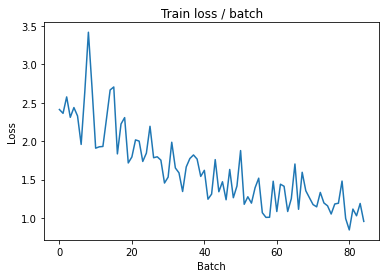


===============> Total time 12s	Avg loss 1.1130	Avg Prec@1 66.96 %	Avg Prec@5 98.21 %

[EVAL Batch 000/004]	Time 2.526s (2.526s)	Loss 1.6207 (1.6207)	Prec@1  43.8 ( 43.8)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.4093	Avg Prec@1 50.00 %	Avg Prec@5 96.88 %



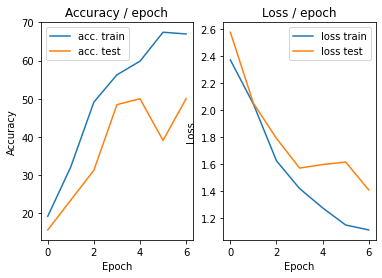

=== EPOCH 8 =====

[TRAIN Batch 000/014]	Time 2.032s (2.032s)	Loss 1.0412 (1.0412)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


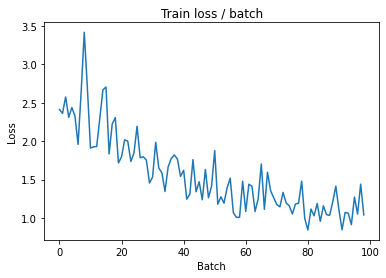


===============> Total time 13s	Avg loss 1.0521	Avg Prec@1 67.41 %	Avg Prec@5 97.32 %

[EVAL Batch 000/004]	Time 2.478s (2.478s)	Loss 1.4371 (1.4371)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.3933	Avg Prec@1 57.81 %	Avg Prec@5 93.75 %



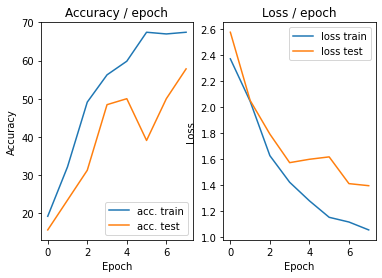

=== EPOCH 9 =====

[TRAIN Batch 000/014]	Time 1.610s (1.610s)	Loss 0.8917 (0.8917)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


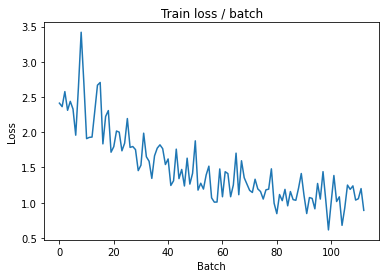


===============> Total time 12s	Avg loss 0.9897	Avg Prec@1 69.64 %	Avg Prec@5 97.32 %

[EVAL Batch 000/004]	Time 2.487s (2.487s)	Loss 1.6899 (1.6899)	Prec@1  31.2 ( 31.2)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.3662	Avg Prec@1 54.69 %	Avg Prec@5 93.75 %



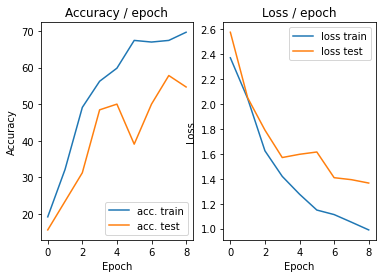

=== EPOCH 10 =====

[TRAIN Batch 000/014]	Time 1.970s (1.970s)	Loss 0.9145 (0.9145)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


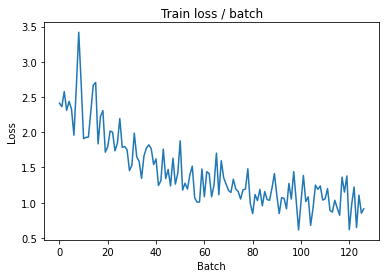


===============> Total time 13s	Avg loss 0.9793	Avg Prec@1 70.54 %	Avg Prec@5 96.88 %

[EVAL Batch 000/004]	Time 2.494s (2.494s)	Loss 1.4732 (1.4732)	Prec@1  37.5 ( 37.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2677	Avg Prec@1 59.38 %	Avg Prec@5 96.88 %



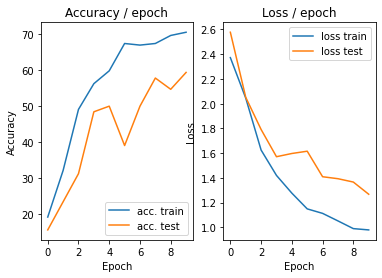

=== EPOCH 11 =====

[TRAIN Batch 000/014]	Time 1.796s (1.796s)	Loss 0.8280 (0.8280)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)


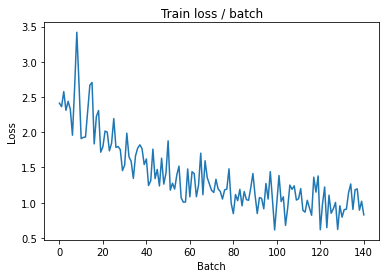


===============> Total time 12s	Avg loss 0.8924	Avg Prec@1 74.11 %	Avg Prec@5 97.77 %

[EVAL Batch 000/004]	Time 2.543s (2.543s)	Loss 1.4842 (1.4842)	Prec@1  37.5 ( 37.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.3231	Avg Prec@1 54.69 %	Avg Prec@5 95.31 %



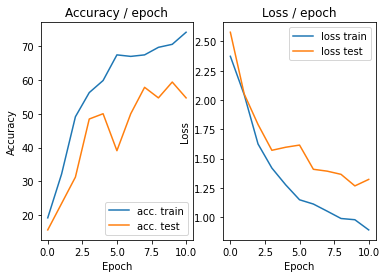

=== EPOCH 12 =====

[TRAIN Batch 000/014]	Time 2.280s (2.280s)	Loss 0.9287 (0.9287)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)


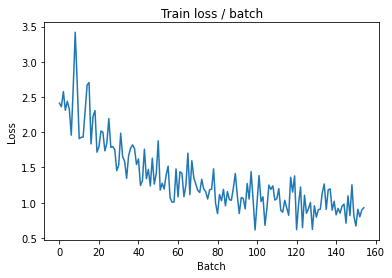


===============> Total time 13s	Avg loss 0.8594	Avg Prec@1 75.00 %	Avg Prec@5 96.88 %

[EVAL Batch 000/004]	Time 2.512s (2.512s)	Loss 1.5774 (1.5774)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2506	Avg Prec@1 57.81 %	Avg Prec@5 100.00 %



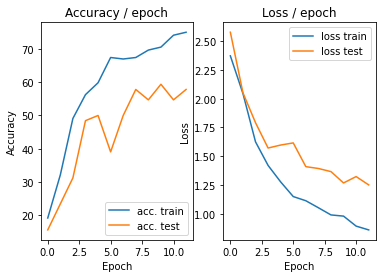

=== EPOCH 13 =====

[TRAIN Batch 000/014]	Time 2.230s (2.230s)	Loss 0.6084 (0.6084)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


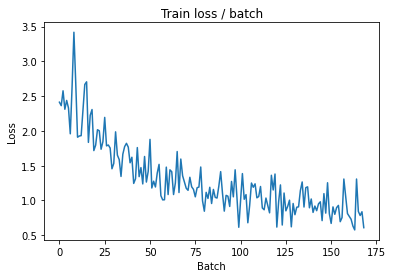


===============> Total time 12s	Avg loss 0.8057	Avg Prec@1 75.89 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.436s (2.436s)	Loss 1.3575 (1.3575)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2661	Avg Prec@1 59.38 %	Avg Prec@5 98.44 %



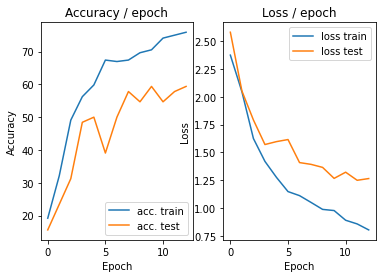

=== EPOCH 14 =====

[TRAIN Batch 000/014]	Time 2.088s (2.088s)	Loss 0.8390 (0.8390)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


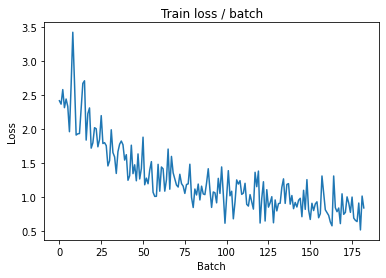


===============> Total time 13s	Avg loss 0.7049	Avg Prec@1 82.59 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.548s (2.548s)	Loss 1.7358 (1.7358)	Prec@1  43.8 ( 43.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.4131	Avg Prec@1 51.56 %	Avg Prec@5 96.88 %



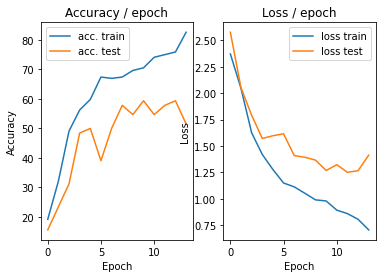

=== EPOCH 15 =====

[TRAIN Batch 000/014]	Time 1.993s (1.993s)	Loss 0.8573 (0.8573)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


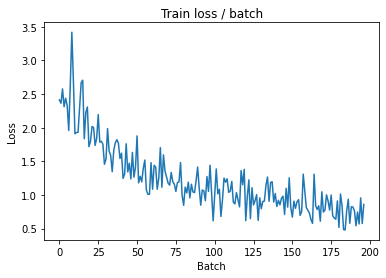


===============> Total time 12s	Avg loss 0.7587	Avg Prec@1 73.66 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.509s (2.509s)	Loss 1.3508 (1.3508)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2801	Avg Prec@1 57.81 %	Avg Prec@5 93.75 %



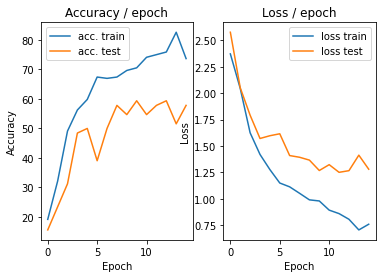

=== EPOCH 16 =====

[TRAIN Batch 000/014]	Time 2.276s (2.276s)	Loss 0.6360 (0.6360)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


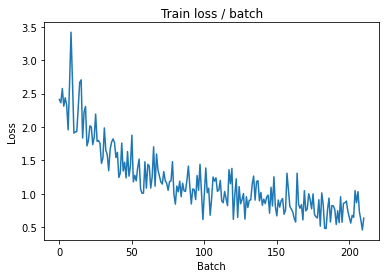


===============> Total time 13s	Avg loss 0.7218	Avg Prec@1 79.02 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.556s (2.556s)	Loss 1.3818 (1.3818)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.3138	Avg Prec@1 50.00 %	Avg Prec@5 96.88 %



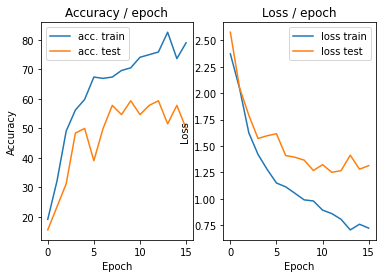

=== EPOCH 17 =====

[TRAIN Batch 000/014]	Time 2.491s (2.491s)	Loss 1.0260 (1.0260)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)


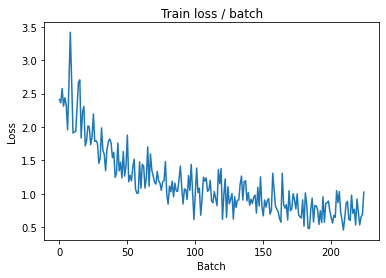


===============> Total time 13s	Avg loss 0.6670	Avg Prec@1 76.79 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.548s (2.548s)	Loss 1.5104 (1.5104)	Prec@1  31.2 ( 31.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1726	Avg Prec@1 62.50 %	Avg Prec@5 100.00 %



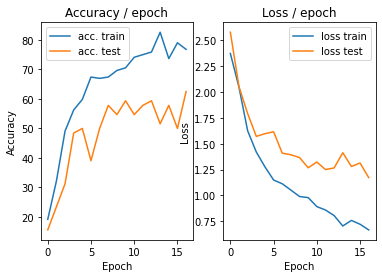

=== EPOCH 18 =====

[TRAIN Batch 000/014]	Time 2.192s (2.192s)	Loss 0.5604 (0.5604)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


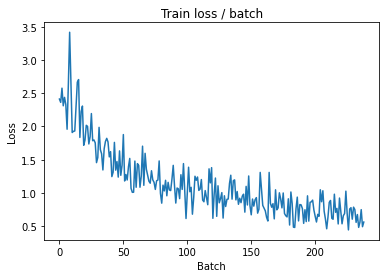


===============> Total time 13s	Avg loss 0.6639	Avg Prec@1 82.14 %	Avg Prec@5 99.11 %

[EVAL Batch 000/004]	Time 2.579s (2.579s)	Loss 1.3548 (1.3548)	Prec@1  43.8 ( 43.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2708	Avg Prec@1 54.69 %	Avg Prec@5 98.44 %



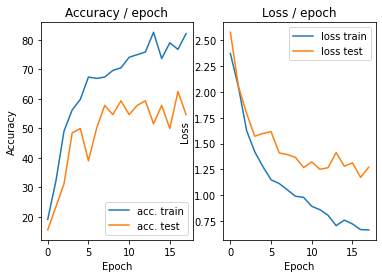

=== EPOCH 19 =====

[TRAIN Batch 000/014]	Time 1.810s (1.810s)	Loss 0.7314 (0.7314)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


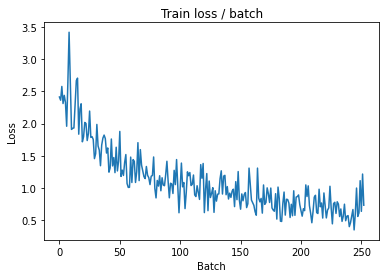


===============> Total time 13s	Avg loss 0.6070	Avg Prec@1 83.48 %	Avg Prec@5 99.11 %

[EVAL Batch 000/004]	Time 2.580s (2.580s)	Loss 1.6126 (1.6126)	Prec@1  43.8 ( 43.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2549	Avg Prec@1 54.69 %	Avg Prec@5 98.44 %



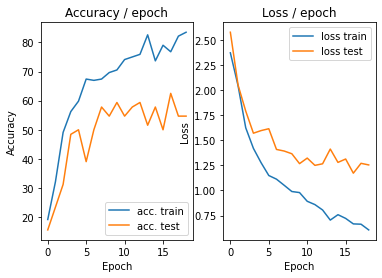

=== EPOCH 20 =====

[TRAIN Batch 000/014]	Time 2.091s (2.091s)	Loss 0.4756 (0.4756)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


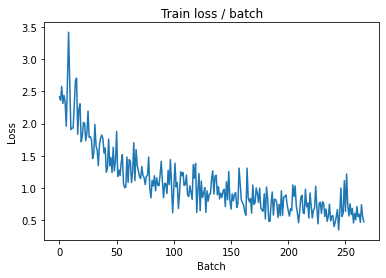


===============> Total time 13s	Avg loss 0.6169	Avg Prec@1 84.82 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.536s (2.536s)	Loss 1.3993 (1.3993)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2032	Avg Prec@1 60.94 %	Avg Prec@5 96.88 %



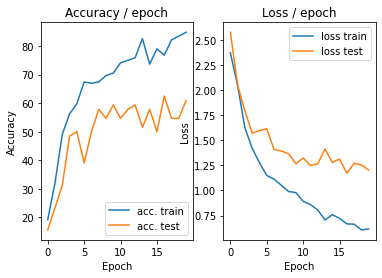

=== EPOCH 21 =====

[TRAIN Batch 000/014]	Time 2.221s (2.221s)	Loss 0.3710 (0.3710)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


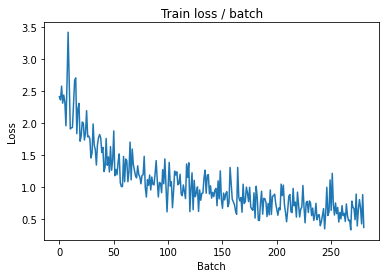


===============> Total time 12s	Avg loss 0.6482	Avg Prec@1 83.93 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.540s (2.540s)	Loss 1.1587 (1.1587)	Prec@1  56.2 ( 56.2)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.0896	Avg Prec@1 62.50 %	Avg Prec@5 96.88 %



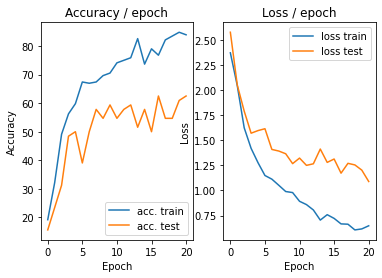

=== EPOCH 22 =====

[TRAIN Batch 000/014]	Time 1.763s (1.763s)	Loss 0.4086 (0.4086)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


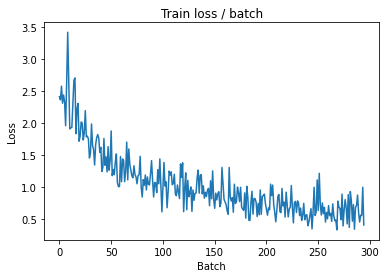


===============> Total time 12s	Avg loss 0.5785	Avg Prec@1 85.27 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.516s (2.516s)	Loss 1.3834 (1.3834)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1533	Avg Prec@1 68.75 %	Avg Prec@5 96.88 %



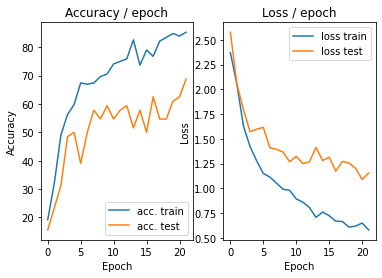

=== EPOCH 23 =====

[TRAIN Batch 000/014]	Time 1.828s (1.828s)	Loss 0.3521 (0.3521)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


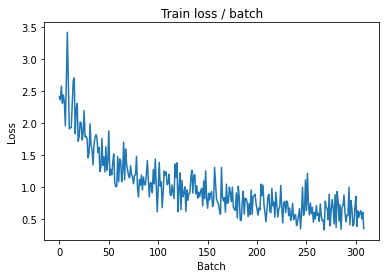


===============> Total time 13s	Avg loss 0.5013	Avg Prec@1 89.73 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.483s (2.483s)	Loss 1.5788 (1.5788)	Prec@1  37.5 ( 37.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2467	Avg Prec@1 51.56 %	Avg Prec@5 96.88 %



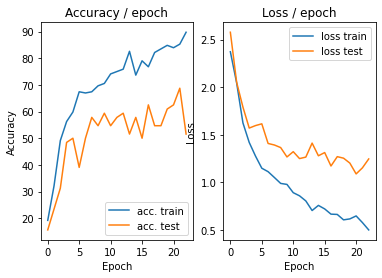

=== EPOCH 24 =====

[TRAIN Batch 000/014]	Time 2.595s (2.595s)	Loss 0.4656 (0.4656)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


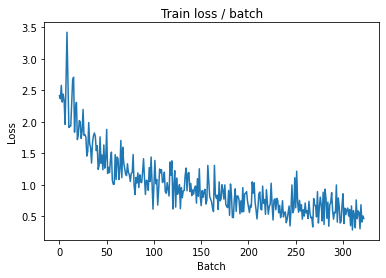


===============> Total time 12s	Avg loss 0.5114	Avg Prec@1 85.27 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.496s (2.496s)	Loss 1.4111 (1.4111)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2488	Avg Prec@1 54.69 %	Avg Prec@5 96.88 %



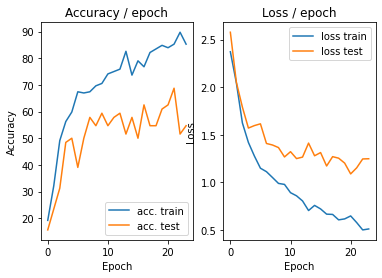

=== EPOCH 25 =====

[TRAIN Batch 000/014]	Time 2.491s (2.491s)	Loss 0.4114 (0.4114)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


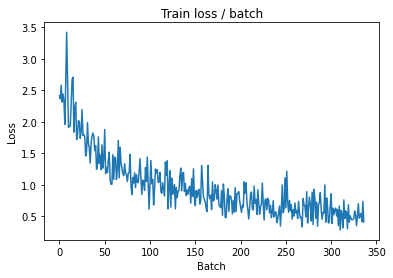


===============> Total time 13s	Avg loss 0.4655	Avg Prec@1 89.29 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.564s (2.564s)	Loss 1.4893 (1.4893)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.0115	Avg Prec@1 62.50 %	Avg Prec@5 100.00 %



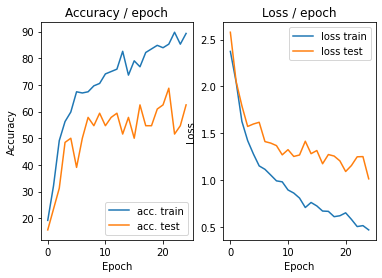

=== EPOCH 26 =====

[TRAIN Batch 000/014]	Time 2.210s (2.210s)	Loss 0.2858 (0.2858)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


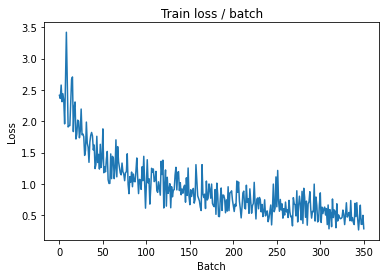


===============> Total time 13s	Avg loss 0.4925	Avg Prec@1 86.16 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.493s (2.493s)	Loss 1.5685 (1.5685)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2257	Avg Prec@1 54.69 %	Avg Prec@5 96.88 %



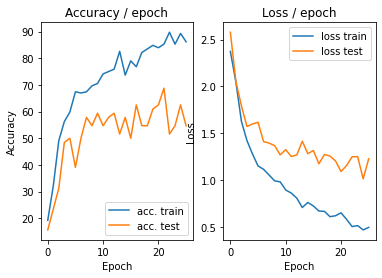

=== EPOCH 27 =====

[TRAIN Batch 000/014]	Time 1.476s (1.476s)	Loss 0.4247 (0.4247)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


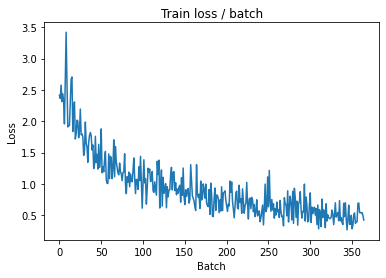


===============> Total time 12s	Avg loss 0.5143	Avg Prec@1 85.71 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.466s (2.466s)	Loss 1.2247 (1.2247)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1448	Avg Prec@1 64.06 %	Avg Prec@5 100.00 %



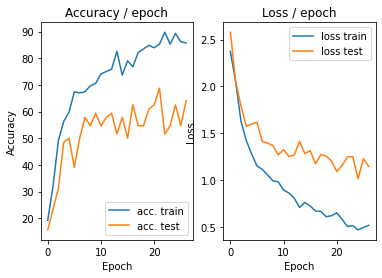

=== EPOCH 28 =====

[TRAIN Batch 000/014]	Time 1.931s (1.931s)	Loss 0.2934 (0.2934)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


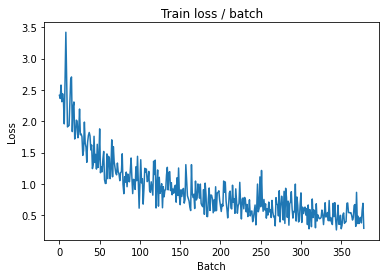


===============> Total time 12s	Avg loss 0.4977	Avg Prec@1 87.05 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.479s (2.479s)	Loss 1.4565 (1.4565)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.1858	Avg Prec@1 56.25 %	Avg Prec@5 95.31 %



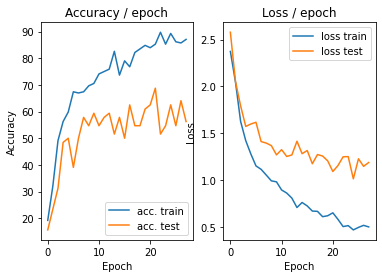

=== EPOCH 29 =====

[TRAIN Batch 000/014]	Time 1.940s (1.940s)	Loss 0.3287 (0.3287)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


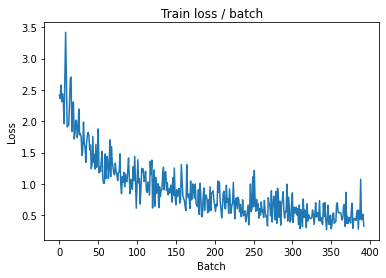


===============> Total time 12s	Avg loss 0.4940	Avg Prec@1 86.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.542s (2.542s)	Loss 1.4075 (1.4075)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.3376	Avg Prec@1 54.69 %	Avg Prec@5 98.44 %



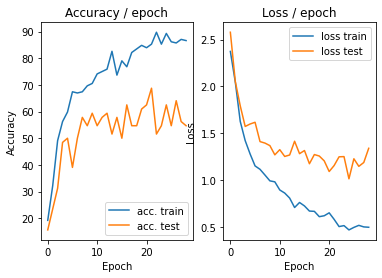

=== EPOCH 30 =====

[TRAIN Batch 000/014]	Time 2.118s (2.118s)	Loss 0.5076 (0.5076)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


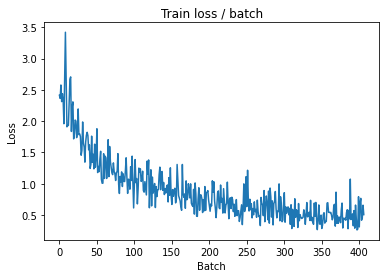


===============> Total time 12s	Avg loss 0.5041	Avg Prec@1 86.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.516s (2.516s)	Loss 1.1960 (1.1960)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1449	Avg Prec@1 59.38 %	Avg Prec@5 96.88 %



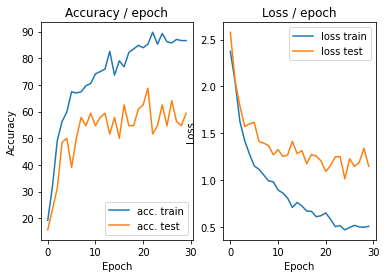

=== EPOCH 31 =====

[TRAIN Batch 000/014]	Time 2.142s (2.142s)	Loss 0.4881 (0.4881)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


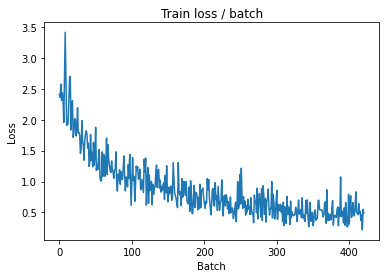


===============> Total time 12s	Avg loss 0.4144	Avg Prec@1 90.18 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.527s (2.527s)	Loss 1.1761 (1.1761)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.0946	Avg Prec@1 57.81 %	Avg Prec@5 98.44 %



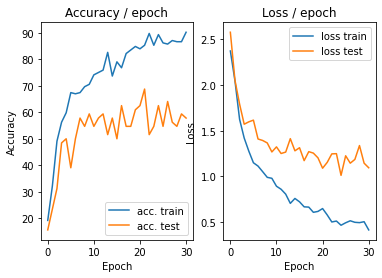

=== EPOCH 32 =====

[TRAIN Batch 000/014]	Time 1.798s (1.798s)	Loss 0.3404 (0.3404)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


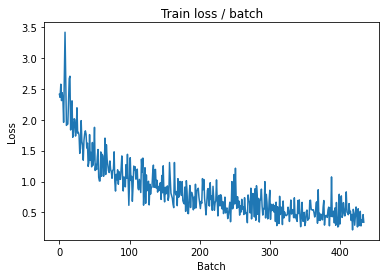


===============> Total time 13s	Avg loss 0.5140	Avg Prec@1 84.82 %	Avg Prec@5 98.66 %

[EVAL Batch 000/004]	Time 2.487s (2.487s)	Loss 1.5997 (1.5997)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2720	Avg Prec@1 50.00 %	Avg Prec@5 96.88 %



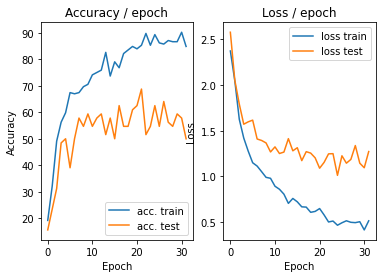

=== EPOCH 33 =====

[TRAIN Batch 000/014]	Time 2.262s (2.262s)	Loss 0.5265 (0.5265)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


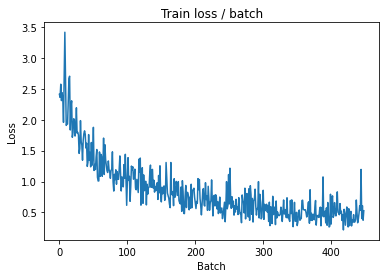


===============> Total time 12s	Avg loss 0.3941	Avg Prec@1 89.73 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.517s (2.517s)	Loss 1.4247 (1.4247)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1930	Avg Prec@1 67.19 %	Avg Prec@5 96.88 %



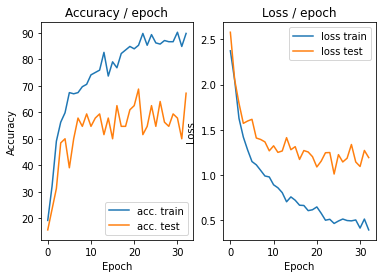

=== EPOCH 34 =====

[TRAIN Batch 000/014]	Time 2.361s (2.361s)	Loss 0.5386 (0.5386)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


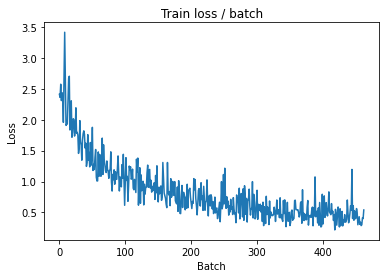


===============> Total time 12s	Avg loss 0.4243	Avg Prec@1 88.84 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.550s (2.550s)	Loss 1.5404 (1.5404)	Prec@1  50.0 ( 50.0)	Prec@5  87.5 ( 87.5)

===============> Total time 3s	Avg loss 1.1865	Avg Prec@1 60.94 %	Avg Prec@5 93.75 %



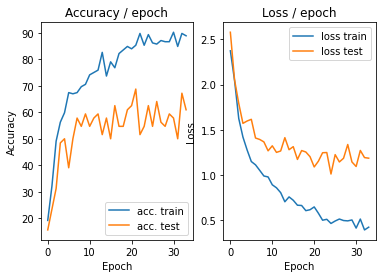

=== EPOCH 35 =====

[TRAIN Batch 000/014]	Time 2.000s (2.000s)	Loss 0.4907 (0.4907)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


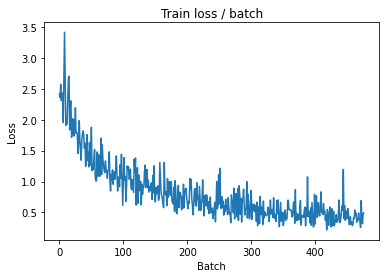


===============> Total time 13s	Avg loss 0.4097	Avg Prec@1 90.62 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.539s (2.539s)	Loss 1.4675 (1.4675)	Prec@1  50.0 ( 50.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2436	Avg Prec@1 64.06 %	Avg Prec@5 96.88 %



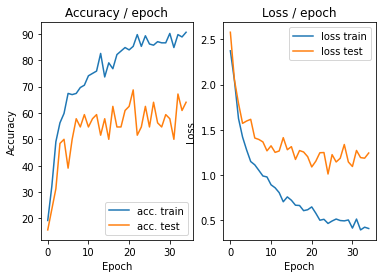

=== EPOCH 36 =====

[TRAIN Batch 000/014]	Time 1.783s (1.783s)	Loss 0.7052 (0.7052)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


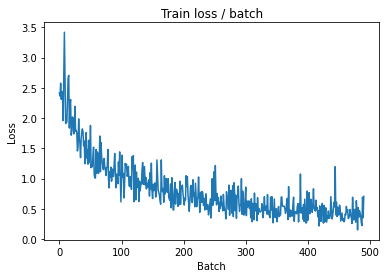


===============> Total time 13s	Avg loss 0.4150	Avg Prec@1 89.73 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.531s (2.531s)	Loss 1.3546 (1.3546)	Prec@1  43.8 ( 43.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1316	Avg Prec@1 62.50 %	Avg Prec@5 96.88 %



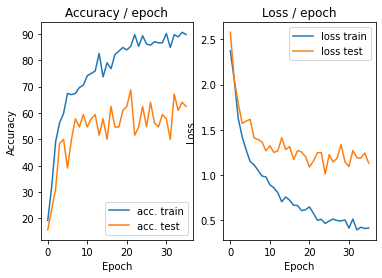

=== EPOCH 37 =====

[TRAIN Batch 000/014]	Time 2.105s (2.105s)	Loss 0.1439 (0.1439)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


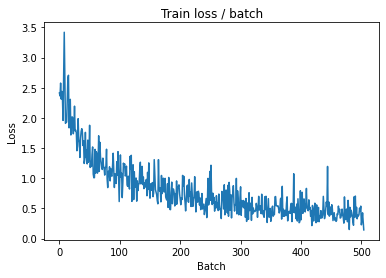


===============> Total time 13s	Avg loss 0.4093	Avg Prec@1 87.50 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.530s (2.530s)	Loss 1.0265 (1.0265)	Prec@1  68.8 ( 68.8)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1739	Avg Prec@1 59.38 %	Avg Prec@5 93.75 %



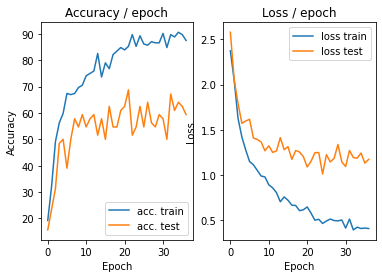

=== EPOCH 38 =====

[TRAIN Batch 000/014]	Time 2.343s (2.343s)	Loss 0.2351 (0.2351)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


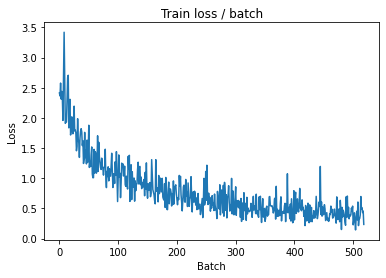


===============> Total time 13s	Avg loss 0.3918	Avg Prec@1 87.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.528s (2.528s)	Loss 1.3274 (1.3274)	Prec@1  37.5 ( 37.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.3180	Avg Prec@1 42.19 %	Avg Prec@5 95.31 %



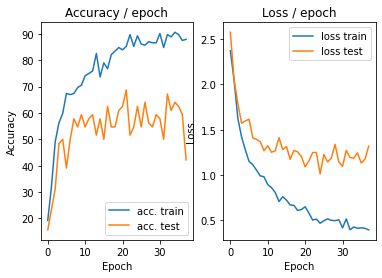

=== EPOCH 39 =====

[TRAIN Batch 000/014]	Time 2.118s (2.118s)	Loss 0.4813 (0.4813)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


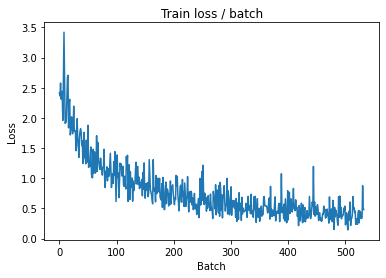


===============> Total time 13s	Avg loss 0.4118	Avg Prec@1 91.96 %	Avg Prec@5 98.66 %

[EVAL Batch 000/004]	Time 2.558s (2.558s)	Loss 1.5244 (1.5244)	Prec@1  43.8 ( 43.8)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2055	Avg Prec@1 53.12 %	Avg Prec@5 95.31 %



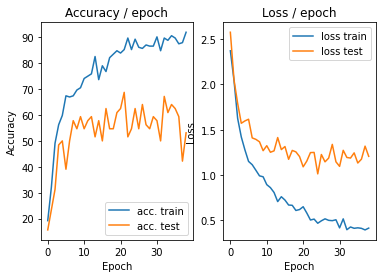

=== EPOCH 40 =====

[TRAIN Batch 000/014]	Time 2.505s (2.505s)	Loss 0.4108 (0.4108)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


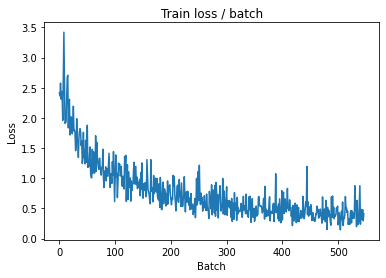


===============> Total time 12s	Avg loss 0.3918	Avg Prec@1 87.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.537s (2.537s)	Loss 1.6898 (1.6898)	Prec@1  50.0 ( 50.0)	Prec@5  87.5 ( 87.5)

===============> Total time 3s	Avg loss 1.1496	Avg Prec@1 62.50 %	Avg Prec@5 95.31 %



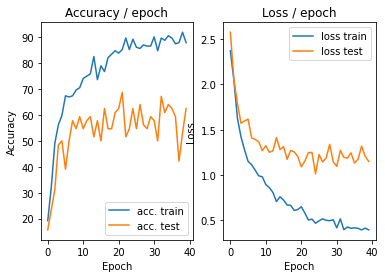

=== EPOCH 41 =====

[TRAIN Batch 000/014]	Time 1.889s (1.889s)	Loss 0.3442 (0.3442)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


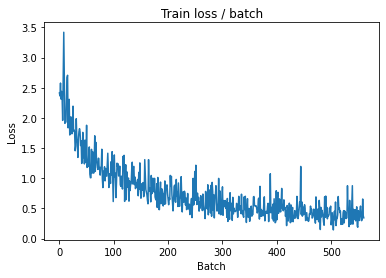


===============> Total time 13s	Avg loss 0.3511	Avg Prec@1 93.30 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.500s (2.500s)	Loss 1.7025 (1.7025)	Prec@1  50.0 ( 50.0)	Prec@5  87.5 ( 87.5)

===============> Total time 3s	Avg loss 1.1303	Avg Prec@1 60.94 %	Avg Prec@5 95.31 %



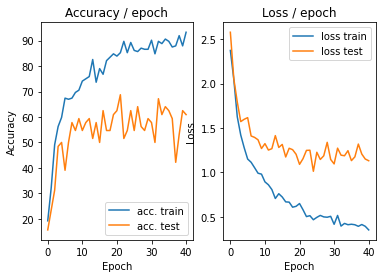

=== EPOCH 42 =====

[TRAIN Batch 000/014]	Time 1.947s (1.947s)	Loss 0.3000 (0.3000)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


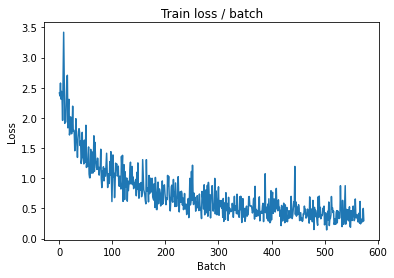


===============> Total time 13s	Avg loss 0.3596	Avg Prec@1 91.52 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.575s (2.575s)	Loss 1.3272 (1.3272)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.3893	Avg Prec@1 54.69 %	Avg Prec@5 98.44 %



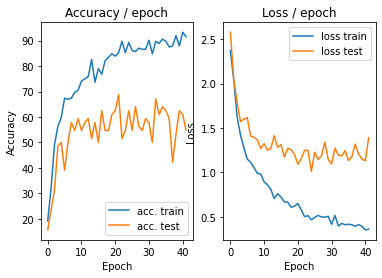

=== EPOCH 43 =====

[TRAIN Batch 000/014]	Time 2.048s (2.048s)	Loss 0.2553 (0.2553)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


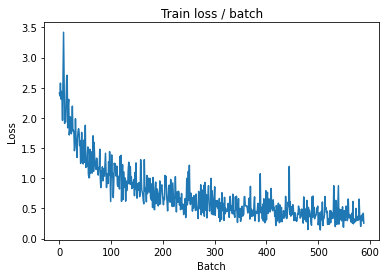


===============> Total time 13s	Avg loss 0.3538	Avg Prec@1 92.41 %	Avg Prec@5 99.55 %

[EVAL Batch 000/004]	Time 2.524s (2.524s)	Loss 1.4684 (1.4684)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.4711	Avg Prec@1 48.44 %	Avg Prec@5 98.44 %



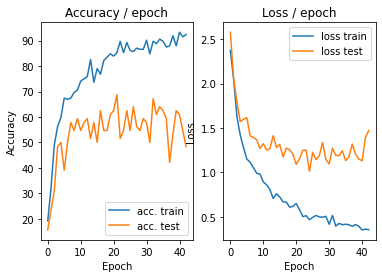

=== EPOCH 44 =====

[TRAIN Batch 000/014]	Time 2.061s (2.061s)	Loss 0.2046 (0.2046)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


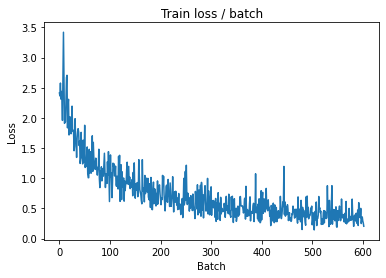


===============> Total time 13s	Avg loss 0.4033	Avg Prec@1 87.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.589s (2.589s)	Loss 1.6301 (1.6301)	Prec@1  62.5 ( 62.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2545	Avg Prec@1 57.81 %	Avg Prec@5 95.31 %



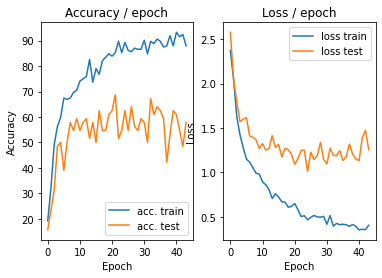

=== EPOCH 45 =====

[TRAIN Batch 000/014]	Time 1.753s (1.753s)	Loss 0.2051 (0.2051)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


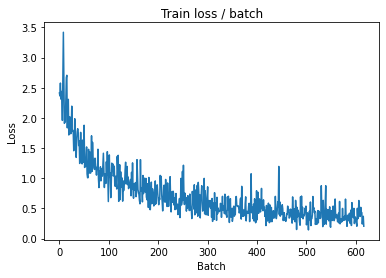


===============> Total time 13s	Avg loss 0.3520	Avg Prec@1 87.50 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.533s (2.533s)	Loss 1.5362 (1.5362)	Prec@1  56.2 ( 56.2)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.2006	Avg Prec@1 60.94 %	Avg Prec@5 100.00 %



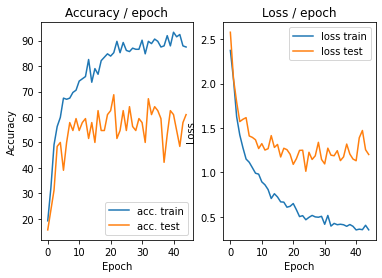

=== EPOCH 46 =====

[TRAIN Batch 000/014]	Time 2.912s (2.912s)	Loss 0.3073 (0.3073)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


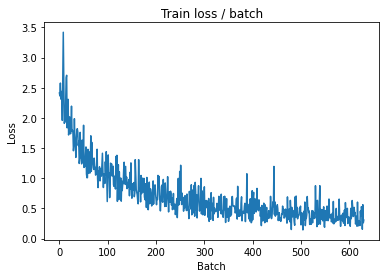


===============> Total time 13s	Avg loss 0.3668	Avg Prec@1 88.39 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.564s (2.564s)	Loss 1.5587 (1.5587)	Prec@1  37.5 ( 37.5)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.2194	Avg Prec@1 57.81 %	Avg Prec@5 98.44 %



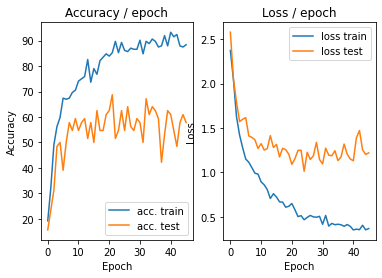

=== EPOCH 47 =====

[TRAIN Batch 000/014]	Time 2.363s (2.363s)	Loss 0.3274 (0.3274)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


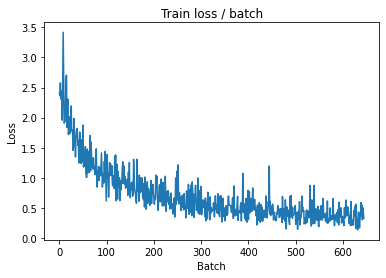


===============> Total time 13s	Avg loss 0.3249	Avg Prec@1 92.41 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.521s (2.521s)	Loss 1.4703 (1.4703)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.1673	Avg Prec@1 56.25 %	Avg Prec@5 98.44 %



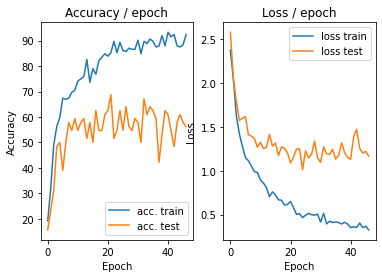

=== EPOCH 48 =====

[TRAIN Batch 000/014]	Time 2.174s (2.174s)	Loss 0.2249 (0.2249)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


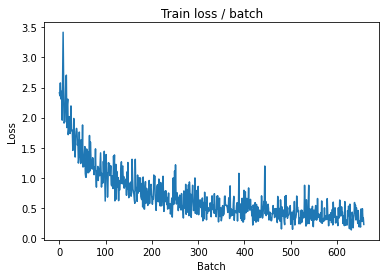


===============> Total time 13s	Avg loss 0.3119	Avg Prec@1 93.30 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.522s (2.522s)	Loss 1.2974 (1.2974)	Prec@1  43.8 ( 43.8)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.0021	Avg Prec@1 65.62 %	Avg Prec@5 98.44 %



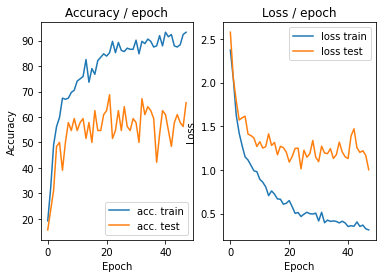

=== EPOCH 49 =====

[TRAIN Batch 000/014]	Time 2.360s (2.360s)	Loss 0.3676 (0.3676)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


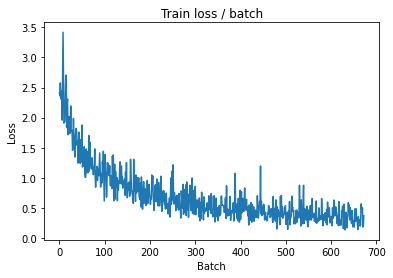


===============> Total time 13s	Avg loss 0.2802	Avg Prec@1 93.75 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.505s (2.505s)	Loss 1.1750 (1.1750)	Prec@1  62.5 ( 62.5)	Prec@5 100.0 (100.0)

===============> Total time 3s	Avg loss 1.3407	Avg Prec@1 56.25 %	Avg Prec@5 98.44 %



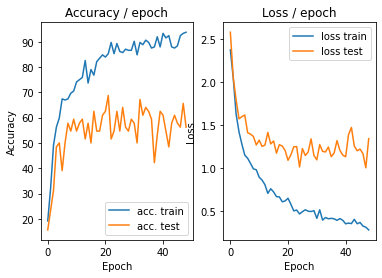

=== EPOCH 50 =====

[TRAIN Batch 000/014]	Time 2.118s (2.118s)	Loss 0.2385 (0.2385)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


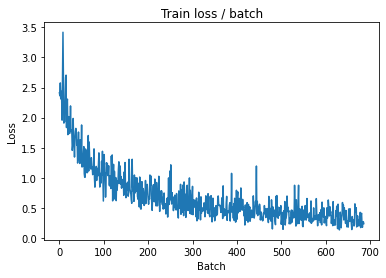


===============> Total time 13s	Avg loss 0.3486	Avg Prec@1 91.96 %	Avg Prec@5 100.00 %

[EVAL Batch 000/004]	Time 2.567s (2.567s)	Loss 1.5817 (1.5817)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.1288	Avg Prec@1 62.50 %	Avg Prec@5 98.44 %



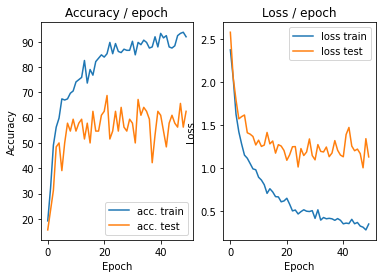

In [ ]:
main(16, 0.001, epochs=50, cuda=True)